# Topic Modelling
Topic Modelling is a form of unsupervised learning that aims to find topic clusters in a series of texts. We will be using LDA, which is one of the most popular forms of doing Topic Modelling



## Imports

In [1]:
import scipy
import gensim
from gensim import corpora
import pandas as pd
from gensim import models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import pprint

## Download Data
Download the data that has been already been prepreprocessed.

In [2]:
letters = pd.read_csv('data/preprocessed_letters.csv')

In [3]:
#check to see what column names we're working with
print(letters.columns)

Index(['keys', 'letter', 'year'], dtype='object')


Extract all the letters and their keys into two separate lists

In [4]:
letterkeys = list(letters["keys"])
lettervalues = list(letters["letter"])

## Additional Preprocessing
Note: a lot of this code was copied from or modified from this tutorial: https://tomvannuenen.medium.com/analyzing-reddit-communities-with-python-part-5-topic-modeling-a5b0d119add, along with referencing code from the "Clustering_TopicModelling" notebook.
We are evaluating the quality of the model using cv Coherence Scores. Originally, creating a model simply using the preprocessed data gave coherence scores of at most 0.38, which is quite poor. The model quality was improved by doing the following:
1. Through trial and error, creating a list of words that appeared in too many topics/were too vague to provide information.
2. Not using a straightforward BOW model, but rather using bigrams and trigrams when possible.
3. Running a search for the optimal number of topic clusters to search for.

The very first model run had a Coherence score of about 0.35, optimizing topic clusters got it to 0.38, then removing common words got it to 0.44, adding bigrams and trigrams to 0.47, and finally searching for optimal topic number gave the final model with a coherence score of 0.51.
and the final model has a score of 0.51. We also tried removing all types of words that were not nouns or adjectives, but the performance of the model dropped rather than improved, so it was left as is.

changed the bigram creation threshold, and the dictioanry filter values
eval_every = 20, chunksize and passes in the model

Additional preprocessing is as follows

The way the preprocessed letters have been stored has removed the tokenization. We can simply split each letter into its own list of tokens once again.

In [5]:
#split into tokens
splitletters = []
for letter in lettervalues:
    splitletters.append(letter.split())

From now on, we will be working with these split letter values

From trial and error, we have noted that there are some words that appear excessively. These have been compiled and manually removed

In [6]:
# List of words to remove
wordstoremove = {"get", "go", "one", "david", "may", "good", "letter", "think", "send", "day", "time", "come", "take", "1917", "well", "say", "tell", "write", "two"
,"know","much","would","make", "could", "would"}

# remove unwanted words
filtered = [
    [word for word in sublist if word not in wordstoremove]
    for sublist in splitletters
]


### Add Bigrams and Trigrams
We used gensim's Phrases to create bigrams and trigrams. Bigrams and trigrams were created out of consecutive words only if the pair/trio of words appeared in at least 5 letters, and if their association strength was a standard 10 (threshold).


In [7]:
bigram = gensim.models.Phrases(filtered, min_count=5, threshold=10)
trigram = gensim.models.Phrases(bigram[filtered], threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
def getngrams(doc):
    bigrams = bigram_mod[doc]          
    trigrams = trigram_mod[bigrams] 
    return trigrams

enrichedtexts = []
for doc in filtered:
    enrichedtexts.append(getngrams(doc))

## Constructing Corpora

We need to create a dictionary out of our data using gensim's Dictionary.

In [9]:
dictionary = corpora.Dictionary(enrichedtexts)
print('Number of unique tokens:', len(dictionary))


Number of unique tokens: 7856


Since the letters already been preprocessed, we will simply remove words that appear in less than 5 letters.

In [10]:
dictionary.filter_extremes(no_below=5, no_above=1)
print('Number of unique tokens:', len(dictionary))

Number of unique tokens: 2070


Create a BOW representation of the documents

In [11]:
bow_corpus = [dictionary.doc2bow(d) for d in enrichedtexts]

Finally we can run a first model.

In [37]:
ldamodel = models.ldamodel.LdaModel(bow_corpus, num_topics=8, id2word = dictionary,
                                           eval_every = 20,
                                           random_state = 100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=40,
                                           alpha='auto',
                                           per_word_topics=True)

# Visualization and First Analysis

We can visualize topic clusters in the following diagram.

In [38]:
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(ldamodel, bow_corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.088039  0.009043       1        1  40.957788
3     -0.098534  0.008674       2        1  40.743159
5     -0.071941  0.023218       3        1  11.747322
2      0.279045  0.295685       4        1   4.345975
6      0.327303 -0.267166       5        1   1.568554
1     -0.113950 -0.014171       6        1   0.302309
0     -0.122001 -0.045096       7        1   0.280792
7     -0.111883 -0.010187       8        1   0.054101, topic_info=            Term        Freq       Total Category  logprob  loglift
313      suppose  110.000000  110.000000  Default  30.0000  30.0000
371        since  116.000000  116.000000  Default  29.0000  29.0000
234         ever   97.000000   97.000000  Default  28.0000  28.0000
114          lot  113.000000  113.000000  Default  27.0000  27.0000
240         fine   74.000000   74.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
826        nerve    0.010444   12.472473   Topic8  -7.6816   0.4369
1814      author    0.010444    2.431874   Topic8  -7.6816   2.0717
680        mount    0.010444   12.287442   Topic8  -7.6816   0.4518
50       darling    0.010444   35.722687   Topic8  -7.6817  -0.6155
1603  positively    0.010443    6.836596   Topic8  -7.6817   1.0380

[472 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
459       1  0.108014      1
459       2  0.594077      1
459       5  0.243031      1
459       7  0.027003      1
461       1  0.138651     10
...     ...       ...    ...
1617      2  0.280637  wound
1617      3  0.712385  wound
332       1  0.674983   yard
332       5  0.321421   yard
2056      4  0.934855    yet

[692 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 3, 7, 2, 1, 8])

The majority of the topics are clustered together and overlap almost completely, which is a sign the topic modelling could be improved. Besides this qualitative analysis, we can compute the coherence score

In [17]:
coherence_model = CoherenceModel(model=ldamodel, corpus=bow_corpus, texts=enrichedtexts, dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)


Coherence Score:  0.4863268369941034


## Optimizing
Now we want to improve on this coherence score by running a search for optimal number of topics
Note: this function was copied from the source previously mentioned. Considering the size of the data, the search for topic number was performed between 3 and 16, with increments of 2.

In [19]:
def compute_coherence_values(dictionary, corpus, letters, limit=16, start=3, step=2):
    """
    Creates a series of models with different numbers of topics and calculates their coherence scores
    
    Args:
    dictionary: for the models' id2word parameter
    corpus: for the models' corpus parameter
    letters: for the coherence model's text parameter
    limit: max number of topics to consider
    start: min number of topics to consider
    step: increment on number of topics

    Returns:
    modellist: list of created models
    coherencelist: list of calculated coherence values
    """    
    coherencelist = []
    modellist = []
    total_amount = limit / step
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                    id2word=dictionary, num_topics=num_topics,
                    random_state=100, update_every=1, chunksize=200, 
                    passes=40, alpha='auto', per_word_topics=False, eval_every = 20)
        modellist.append(model)
        coherencemodel = CoherenceModel(model=model, texts=letters,   
                    dictionary=dictionary, coherence='c_v')  
        coherencelist.append(coherencemodel.get_coherence())
        print("Built Model")
    return modellist, coherencelist

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, letters=enrichedtexts)

Built Model
Built Model
Built Model
Built Model
Built Model
Built Model
Built Model


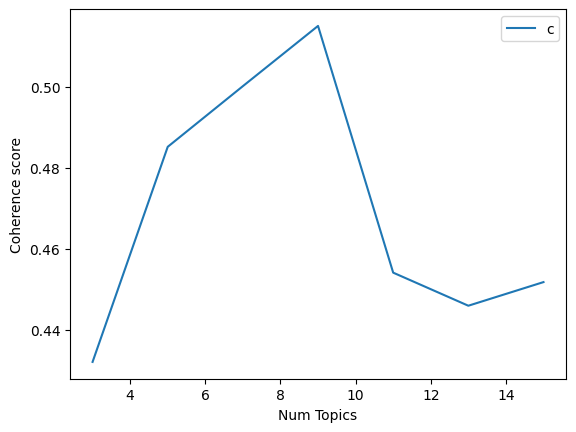

In [22]:
%matplotlib inline
limit=16; start=3; step=2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
print("The coherence score of the best model is: ", coherence_values[3])

The coherence score of the best model is:  0.515131040998454


It appears the best model is the 4th one, with a coherence score of 0.515, and coherence scores drop off sharply after the number of topics hits the double digits.
We will be using model 4 from our search as our optimal model.

# Results
We can look at the top words for the optimal model

In [29]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint.pp(optimal_model.print_topics(num_words=20))

[(0,
  '0.039*"soap" + 0.023*"milk" + 0.021*"scenery" + 0.019*"1" + 0.019*"tin" + '
  '0.019*"oat" + 0.017*"biscuit" + 0.014*"beef" + 0.012*"machine_gun" + '
  '0.012*"ration" + 0.011*"paul" + 0.011*"beg" + 0.010*"pudding" + 0.009*"lb" '
  '+ 0.009*"jam" + 0.008*"meat" + 0.007*"ham" + 0.007*"linn" + 0.005*"bacon" + '
  '0.005*"cigarette"'),
 (1,
  '0.018*"author" + 0.013*"pair_stocking" + 0.009*"lesson" + 0.008*"jump" + '
  '0.007*"to-day" + 0.007*"campbell" + 0.007*"band" + 0.006*"sing" + '
  '0.005*"remark" + 0.004*"jan" + 0.003*"burst" + 0.003*"etc." + 0.003*"alter" '
  '+ 0.002*"burn" + 0.001*"decide" + 0.000*"slowly" + 0.000*"hundred" + '
  '0.000*"quarter" + 0.000*"0" + 0.000*"lieutenant"'),
 (2,
  '0.019*"section" + 0.018*"let" + 0.016*"lot" + 0.015*"regiment" + '
  '0.012*"receive" + 0.012*"officer" + 0.012*"army" + 0.012*"since" + '
  '0.011*"back" + 0.011*"little" + 0.011*"fine" + 0.011*"chap" + '
  '0.011*"platoon" + 0.008*"sincerely" + 0.008*"put" + 0.008*"bad" + '
  '0.008

In [30]:
pyLDAvis.enable_notebook()
viz_optimal = gensimvis.prepare(optimal_model, bow_corpus, dictionary)
viz_optimal

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.066906  0.067640       1        1  32.297645
4     -0.088465 -0.079062       2        1  25.367377
8     -0.088805  0.005380       3        1  22.044678
5     -0.083526 -0.039511       4        1  13.561198
2      0.320492  0.256053       5        1   4.717571
6      0.347792 -0.241182       6        1   1.426301
0     -0.120292  0.009483       7        1   0.468410
1     -0.112065  0.009897       8        1   0.096306
7     -0.108225  0.011301       9        1   0.020514, topic_info=               Term        Freq       Total Category  logprob  loglift
114             lot  112.000000  112.000000  Default  30.0000  30.0000
446            show   69.000000   69.000000  Default  29.0000  29.0000
369         receive  121.000000  121.000000  Default  28.0000  28.0000
572            best   87.000000   87.000000  Default  27.0000  27.0000
990             1st   67.000000   67.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1278         action    0.004080    7.686005   Topic9  -7.6519   0.9507
1788  cheeky_beggar    0.004079    7.311074   Topic9  -7.6519   1.0007
1841          beast    0.004079    5.733281   Topic9  -7.6519   1.2438
1047          mixed    0.004079   13.054175   Topic9  -7.6519   0.4209
1933       shocking    0.004079    5.873130   Topic9  -7.6519   1.2196

[527 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1112      3  0.274582          0
1112      4  0.686455          0
459       1  0.537400          1
459       2  0.141421          1
459       5  0.197989          1
...     ...       ...        ...
2031      5  0.748237       year
2032      6  0.826810  yesterday
2056      5  0.911608        yet
1250      3  0.928673        £20
1571      4  0.933057        £40

[855 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 9, 6, 3, 7, 1, 2, 8])

With pyLDAvis we can visualize the topics. Hovering over each topic shows the top 30 most salient words per topic.
Note: the topic numbering is not in line with the previous topic numbering seen when printing. The topics are numbered in decreasing topic size.
Compared with the first model, the topics are not as clustered, with 2 very separate topics (5 and 6), and the rest somewhat overlapping, but still an improvement. Topics 7,8,9 are extremely small, but the topics 8 and 9 have very strong overaching themes in their salient terms (while 9 is negligible).

# Heatmap
We can also see which topics are most prevalent by using a heatmap.
Note: code for the heatmap was copied from the course's notebook on the topic.

In [32]:
import numpy as np

docs_id = letterkeys

doc2topics = np.zeros((len(docs_id), optimal_model.num_topics))

for di, doc_topics in enumerate(optimal_model.get_document_topics(bow_corpus, minimum_probability = 0)):
    for ti, v in doc_topics:
        doc2topics[di, ti] = v

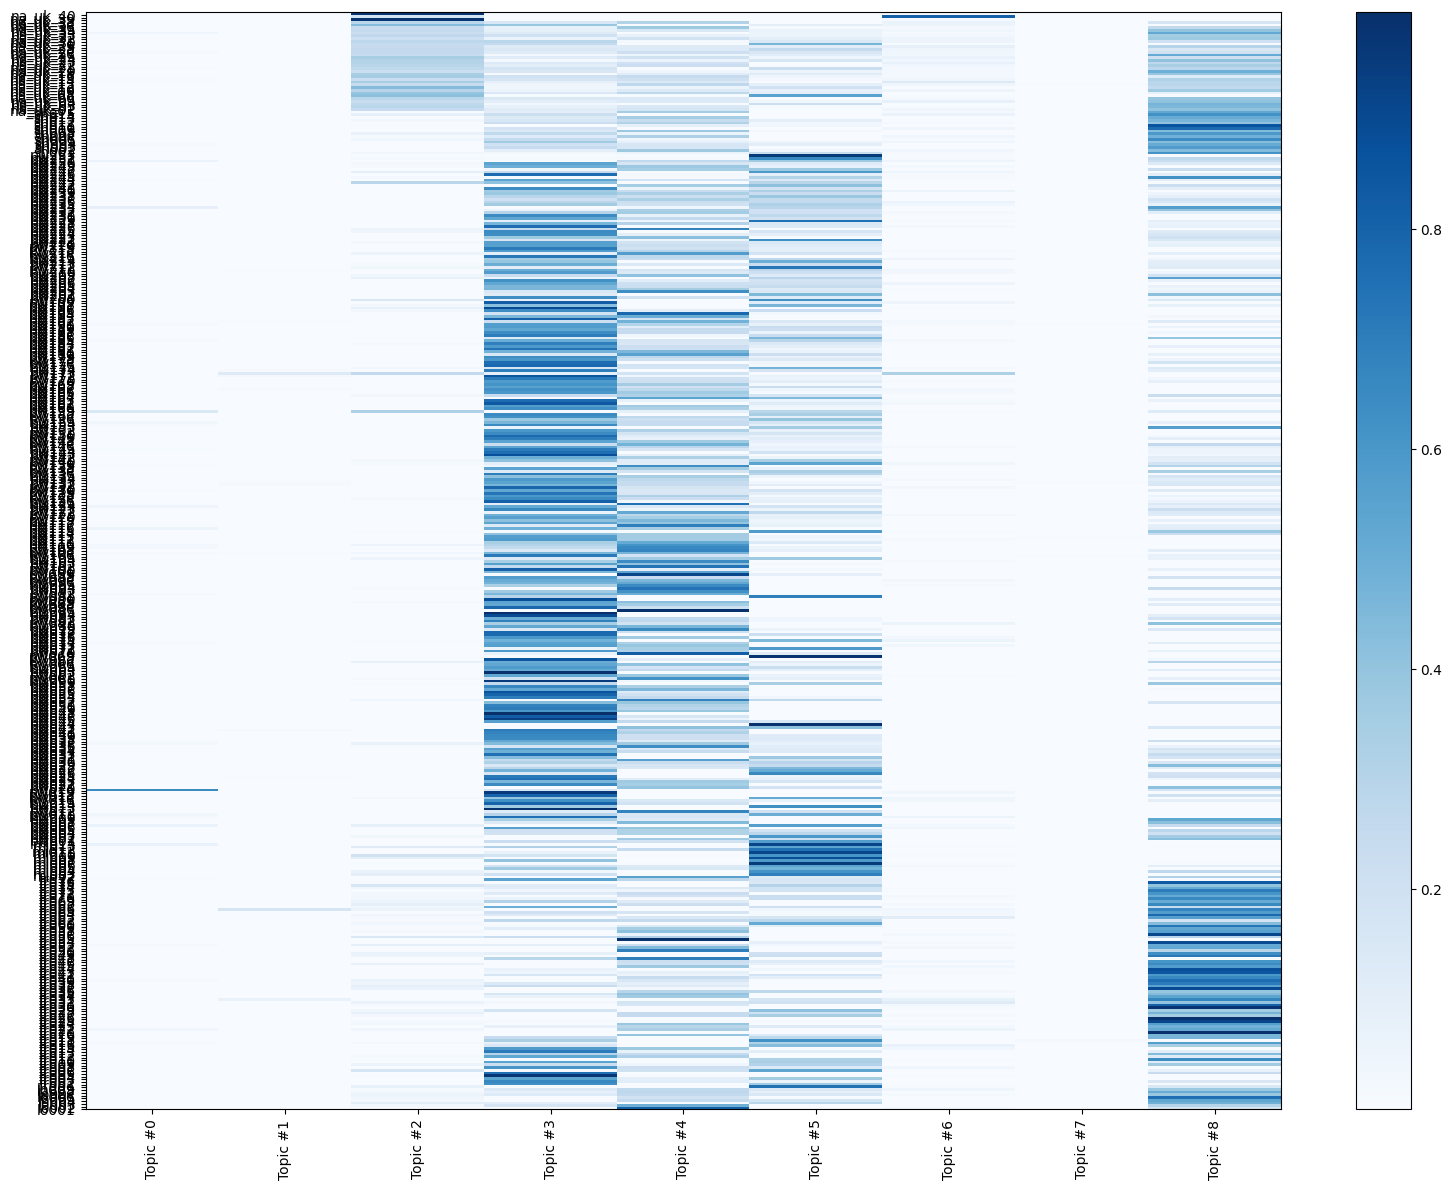

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics, norm=None, cmap='Blues')
plt.yticks(np.arange(doc2topics.shape[0]), docs_id)
plt.xticks(np.arange(doc2topics.shape[1])+0.5, ["Topic #"+str(n) for n in range(optimal_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.show()

As seen in the pyLDAvis model, only 4 of the 9 topics are very salient and account for a significant percentage of the dataset. 
The following code was taken from the course's notebook 12_Clustering_TopicModelling

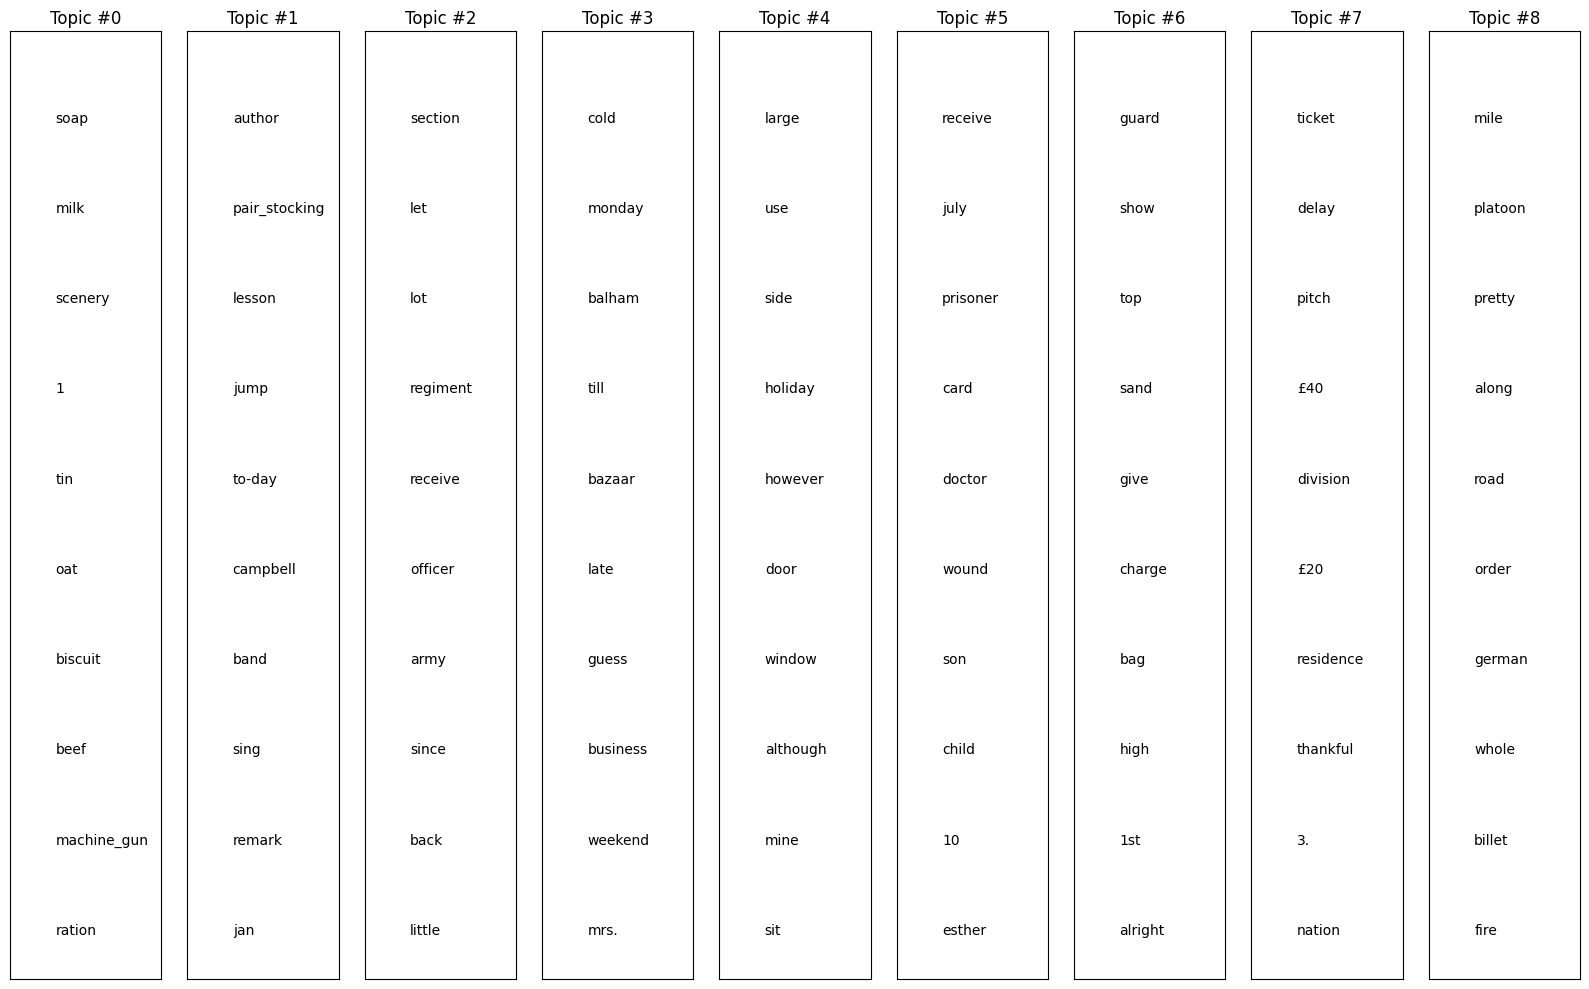

In [36]:
fig = plt.figure(figsize=(16, 10))

num_top_words = 10

topic2top_words = dict(optimal_model.show_topics(formatted=False, num_words = num_top_words))
fontsize_base = 25 / max([w[0][1] for w in topic2top_words.values()]) # font size for word with largest share in corpus

for topic, words_shares in topic2top_words.items():
    plt.subplot(1, optimal_model.num_topics, topic + 1)
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(topic))
    for i, (word, share) in enumerate(words_shares):
        plt.text(0.3, num_top_words-i-0.5, word)
        
plt.tight_layout()
plt.show()